# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [762]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the years (2013-2024) from CSV files. The data is then concatenated into a single DataFrame for analysis.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [765]:
# Use all the years available, including up to recently
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 3586857


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [767]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
3530304,20240628110057PD,10069330,6/28/2024 12:00:00 AM,P241800258,2,6/28/2024 12:00:00 AM,6/28/2024 12:00:00 AM,10:10:13,WELCKEMS,WELFARE CHECK (COMBINED EVENT),N,No report required; dispatch record only,[1100]-[1200] WHIRLOW PL,San Jose,CA,37.377746,-121.870449,Vinci Park
760000,20150606013027PD,5799506,5/13/2021 12:00:00 AM,P151570076,6,6/6/2015 12:00:00 AM,6/6/2015 12:00:00 AM,01:19:15,1195,VEHICLE STOP,N,No report required; dispatch r,THE ALAMEDA & CLEAVES AV,San Jose,CA,37.335429,-121.916024,Alameda
2273258,20200311103508PD,8073729,5/15/2021 12:00:00 AM,P200710332,2,3/11/2020 12:00:00 AM,3/11/2020 12:00:00 AM,10:02:36,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch r,[1800]-[1900] W SAN CARLOS ST,San Jose,CA,37.323208,-121.926934,Parkmoor
38163,20130218105706PS,4741857,5/13/2021 12:00:00 AM,P130490224,2,2/18/2013 12:00:00 AM,2/18/2013 12:00:00 AM,09:34:29,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch r,[3000]-[3100] IRONSIDE CT,San Jose,CA,37.409697,-121.863572,Majestic
2226766,20200116225838PS,8002078,5/15/2021 12:00:00 AM,P200160874,3,1/16/2020 12:00:00 AM,1/16/2020 12:00:00 AM,20:43:01,1182,"VEHICLE ACCIDENT, PROPERTY DAM",N,No report required; dispatch r,[2600]-[2700] VISTA VERDE DR,San Jose,CA,37.338653,-121.795928,Valle Vista


In [768]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586857 entries, 0 to 3586856
Data columns (total 18 columns):
 #   Column            Dtype  
---  ------            -----  
 0   CDTS              object 
 1   EID               int64  
 2   START_DATE        object 
 3   CALL_NUMBER       object 
 4   PRIORITY          int64  
 5   REPORT_DATE       object 
 6   OFFENSE_DATE      object 
 7   OFFENSE_TIME      object 
 8   CALLTYPE_CODE     object 
 9   CALL_TYPE         object 
 10  FINAL_DISPO_CODE  object 
 11  FINAL_DISPO       object 
 12  ADDRESS           object 
 13  CITY              object 
 14  STATE             object 
 15  LATITUDE          float64
 16  LONGITUDE         float64
 17  neighborhood      object 
dtypes: float64(2), int64(2), object(14)
memory usage: 492.6+ MB


In [769]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.586857e+06,3.586857e+06,3.217154e+06,3.217154e+06
mean,7.367982e+06,3.250629e+00,3.732100e+01,-1.218711e+02
std,1.576600e+06,1.369408e+00,4.303979e-02,4.786456e-02
min,4.684476e+06,0.000000e+00,3.400982e+01,-1.220357e+02
25%,5.997906e+06,2.000000e+00,3.729686e+01,-1.219022e+02
50%,7.339761e+06,3.000000e+00,3.732443e+01,-1.218690e+02
75%,8.721333e+06,4.000000e+00,3.734905e+01,-1.218384e+02
max,1.016501e+07,8.000000e+00,3.753923e+01,-1.179017e+02


In [770]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,3586857,3586857,3586857,3586857,3586857,3586857,3586857,3586249,3586857,3586857,3472489,3586857,3586857,3200962
unique,3560324,1124,3492585,4264,4264,92069,232,248,25,25,85195,1,1,295
top,20150129195025PS,5/14/2021 12:00:00 AM,P132070252,7/4/2015 12:00:00 AM,7/4/2015 12:00:00 AM,18:15:00,415,DISTURBANCE,N,No report required; dispatch r,Not a valid geographical locat,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,1270415,10,1305,1305,88,351805,351752,1559306,1115053,12249,3586857,3586857,96800


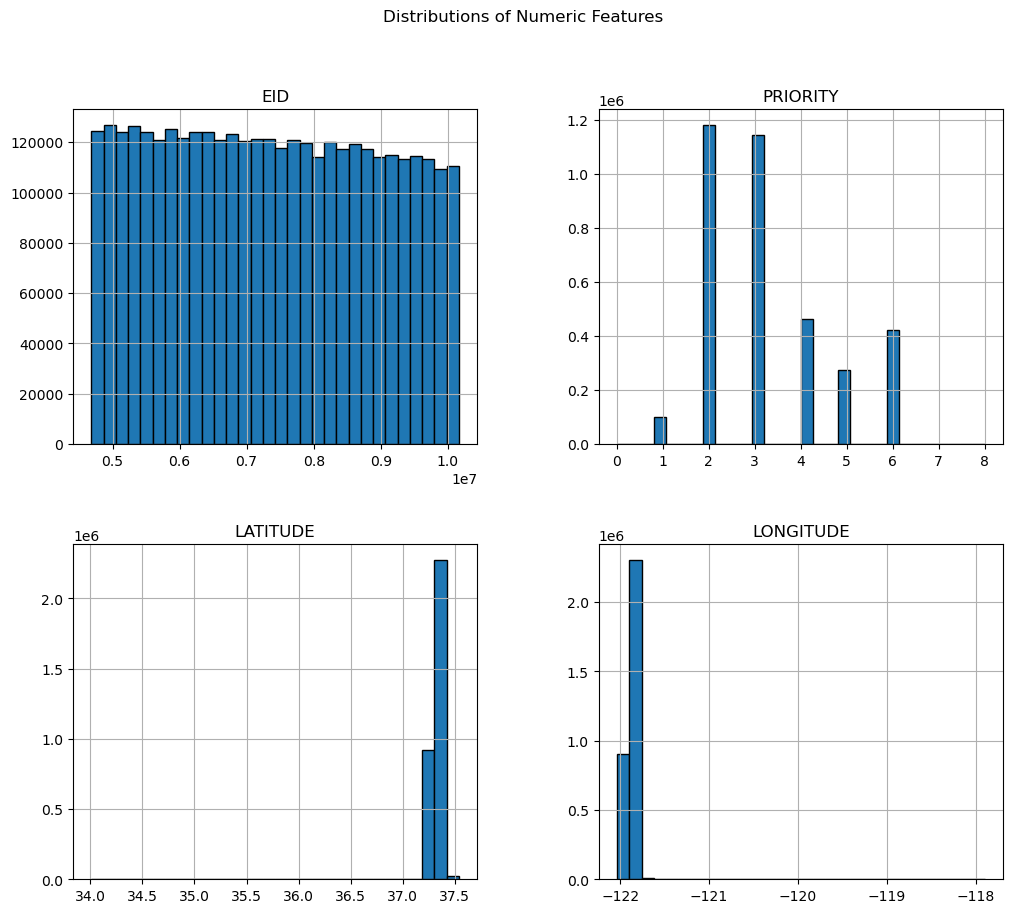

In [771]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [772]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                     0
EID                      0
START_DATE               0
CALL_NUMBER              0
PRIORITY                 0
REPORT_DATE              0
OFFENSE_DATE             0
OFFENSE_TIME             0
CALLTYPE_CODE            0
CALL_TYPE              608
FINAL_DISPO_CODE         0
FINAL_DISPO              0
ADDRESS             114368
CITY                     0
STATE                    0
LATITUDE            369703
LONGITUDE           369703
neighborhood        385895
dtype: int64

In [773]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [774]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 3560324 unique values
START_DATE: 1124 unique values
CALL_NUMBER: 3492585 unique values
REPORT_DATE: 4264 unique values
OFFENSE_DATE: 4264 unique values
OFFENSE_TIME: 92069 unique values
CALLTYPE_CODE: 232 unique values
CALL_TYPE: 248 unique values
FINAL_DISPO_CODE: 25 unique values
FINAL_DISPO: 25 unique values
ADDRESS: 85195 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [775]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      96800
Little Saigon and Spring Brook    60327
Five Wounds-San Jose High         52208
Trimble Business Area             52204
Fruitdale and Sherman Oaks        48479
                                  ...  
Villages                            636
Linda Vista and Hillcrest           425
Meadowlands                         420
Alta Vista                          362
Santa Teresa Hills                  312
Name: count, Length: 295, dtype: int64

In [776]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          1559306
CAN         604855
R           411013
G           208504
NR          129431
E            87956
D            73575
A            72429
DUPNCAN      66338
GD           64382
O            57016
H            48760
ADV          44845
C            40362
T            37698
U            36510
B            30894
F            10620
M             1019
P              745
Z              423
TOT            172
DUP              2
ESNT             1
AA               1
Name: count, dtype: int64

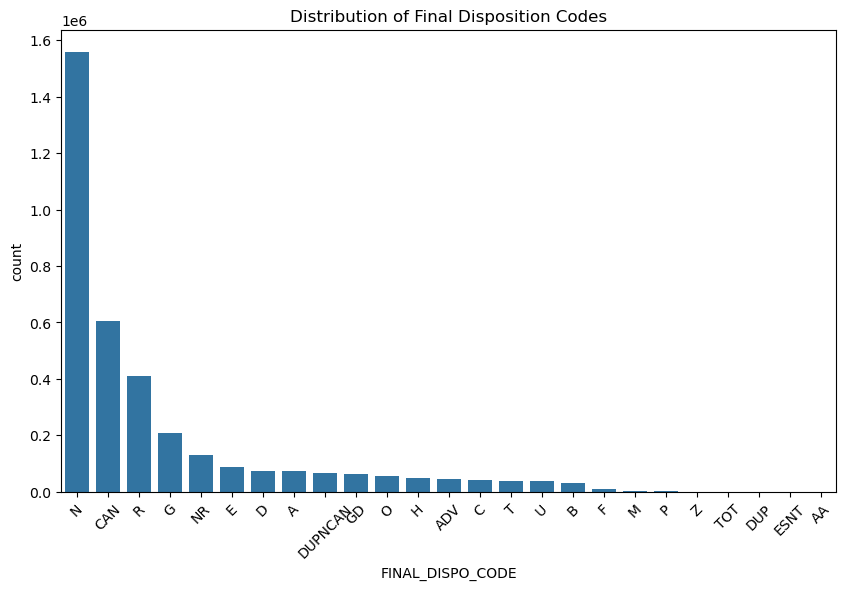

In [777]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [778]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r                      1115053
Canceled                                             604855
No report required; dispatch record only             444253
Report taken                                         411013
No Disposition                                       176164
Gone on Arrival/unable to loca                       160776
No Response                                          129431
Arrest Made                                           72429
Traffic Citation Issued, Non-H                        70693
Supplemental report taken                             57016
Gone on Arrival/unable to locate                      47728
Traffic Citation Issued, Hazar                        46767
Criminal Citation                                     40362
Courtesy Service/Citizen or ag                        37887
Turned over To (TOT)                                  37698
Unfounded event                                       36510
Arrest by Warrant           

In [779]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'NR': 'No Response',
 'G': 'Gone on Arrival/unable to locate',
 'CAN': 'Canceled',
 'N': 'No report required; dispatch record only',
 'DUPNCAN': 'No Disposition',
 'R': 'Report taken',
 'GD': 'No Disposition',
 'O': 'Supplemental report taken',
 'H': 'Courtesy Service/Citizen or agency assist',
 'A': 'Arrest Made',
 'T': 'Turned over To (TOT)',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'F': 'Field Interview (F.I.) Completed',
 'ADV': 'No Disposition',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'P': 'Prior case, follow-up activity only',
 'C': 'Criminal Citation',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'M': 'Stranded motorist assist',
 'ESNT': 'No Disposition',
 'DUP': 'No Disposition',
 'Z': 'No Disposition',
 'TOT': 'No Disposition',
 'AA': 'No Disposition'}

In [780]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'415FC': 'DISTURBANCE, FIRECRACKERS',
 '1062': 'MEET THE CITIZEN',
 '1057': 'FIREARMS DISCHARGED',
 '415F': 'DISTURBANCE, FAMILY',
 '647F': 'DRUNK IN PUBLIC',
 '1033A': 'ALARM, AUDIBLE',
 '5150': 'MENTALLY DISTURBED PERSON',
 '1065X': 'MISSING FEMALE',
 '1033S': 'ALARM, SILENT',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '23103': 'RECKLESS DRIVING',
 '415M': 'DISTURBANCE, MUSIC',
 '1033': 'ALARM',
 '911CELL': 'UNK TYPE 911 CALL FROM CELL',
 '23152': 'MISDEMEANOR DUI',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '415A': 'DISTURBANCE, FIGHT',
 '10851': 'STOLEN VEHICLE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAMAGE',
 '415': 'DISTURBANCE',
 '1154': 'SUSPICIOUS VEHICLE',
 '1066': 'SUSPICIOUS PERSON',
 '1067X': 'FEMALE CALLING FOR HELP',
 '1070': 'PROWLER',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '242': 'BATTERY',
 '22500': 'PARKING VIOLATION',
 '1195': 'VEHICLE STOP',
 '1095': 'PEDESTRIAN STOP',
 '1125': 'TRAFFIC HAZARD',
 '1179': 'VEHICLE ACCIDENT, AMB DISPATCHED',
 '537': 'DEFRAUDING AN INKEEPER',
 '

## Focus on Target Dispositions

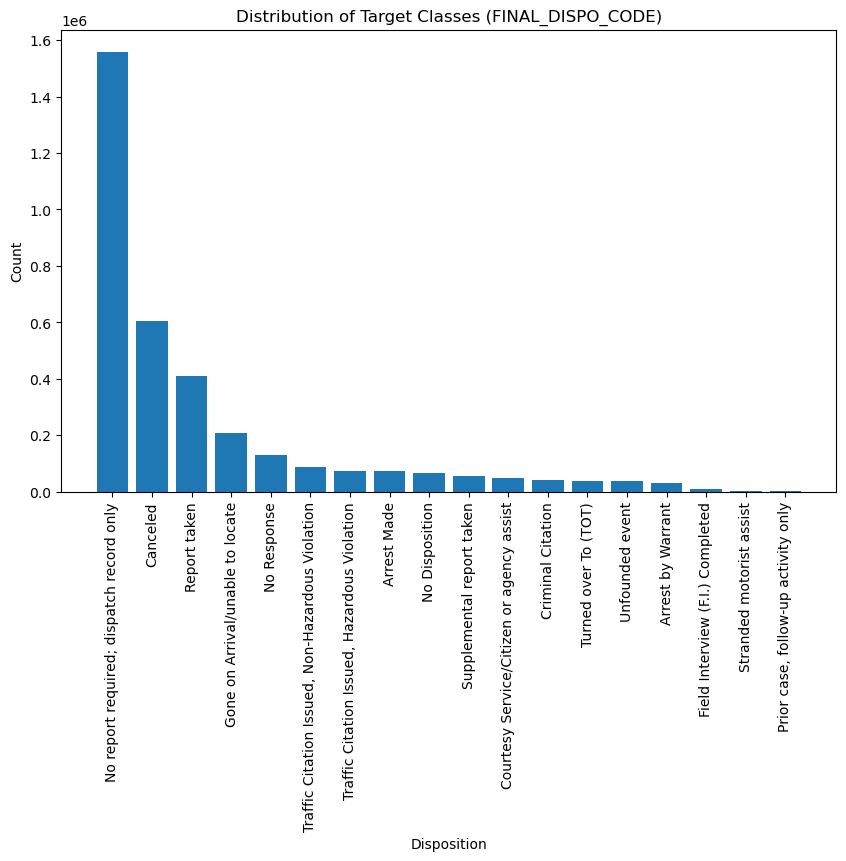

In [782]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [783]:
model_utils.transform_offense_date(all_police_df)

In [784]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    3443172
A          72429
C          40362
B          30894
Name: count, dtype: int64

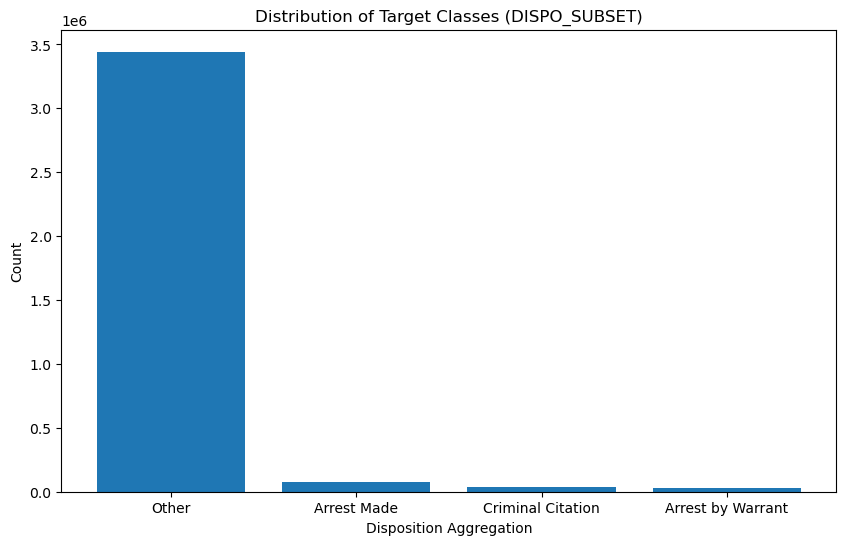

In [785]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

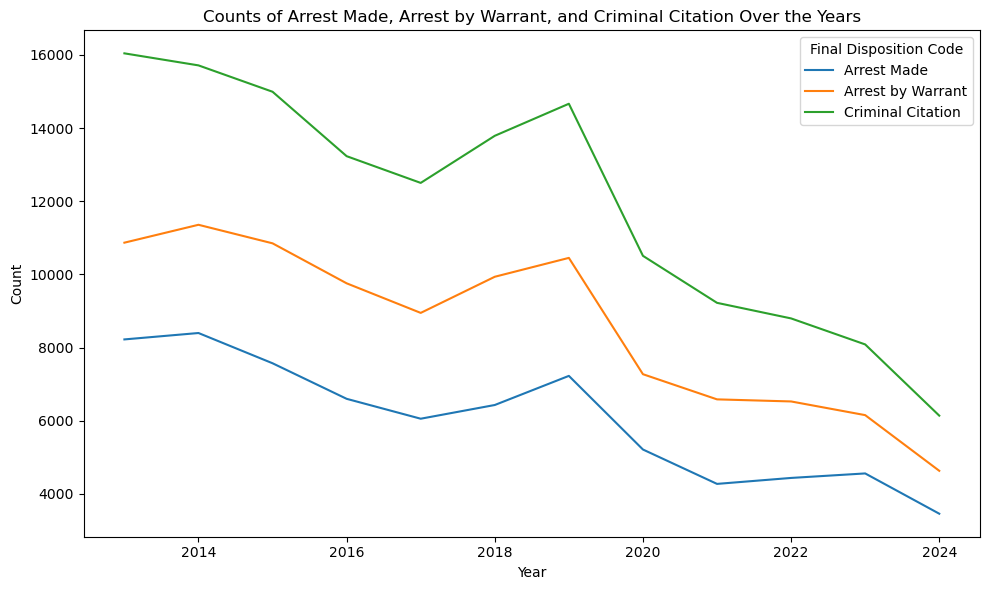

In [786]:
# Filter the dataframe to include only the relevant disposition codes
filtered_df = all_police_df[all_police_df['FINAL_DISPO_CODE'].isin(['A', 'B', 'C'])]

# Group by year and final disposition code and count occurrences
dispo_counts = filtered_df.groupby(['OFFENSE_YEAR', 'FINAL_DISPO_CODE']).size().unstack(fill_value=0)

# Rename columns to use the disposition names instead of codes
dispo_counts.rename(columns=dispo_mapping, inplace=True)

# Plot the graph
dispo_counts.plot(kind='line', stacked=True, figsize=(10, 6))

# Add title and labels
plt.title('Counts of Arrest Made, Arrest by Warrant, and Criminal Citation Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Final Disposition Code')

# Show the plot
plt.tight_layout()
plt.savefig('images/final_disps_over_years.png')
plt.show()


## Data Cleaning and Feature Engineering

The `clean_and_transform_data` function performs data cleaning and transformation on the Police Calls dataset.

### Steps:
1. **Drop unnecessary columns:**
    - Columns like `CDTS`, `EID`, `CALL_NUMBER`, `START_DATE`, `REPORT_DATE`, `CITY`, `STATE`, 
      `CALL_TYPE`, `FINAL_DISPO`, `FINAL_DISPO_CODE`, and `ADDRESS` are removed as they are not 
      needed for the analysis or model building.
  
2. **Remove rows with any missing values:**
    - All rows with missing values are removed, as the missing data corresponds to address information.
    - Since imputing missing address information is not straightforward (e.g., there’s no reliable way to infer missing latitude and longitude data), it was decided to drop these rows rather than risk introducing incorrect or unreliable data.
    - Additionally, retaining incomplete data could negatively impact the quality of the analysis or model accuracy, making removal a more practical choice in this case.
    - Print the number of rows before and after cleaning to keep track of how many records were removed.

3. **Drop the `OFFENSE_DATE` and `OFFENSE_TIME` columns:**
    - These columns are dropped after any necessary features have been extracted, as they are no longer needed.

4. **Calculate the Euclidean distance from the center of San Jose:**
    - Using San Jose's approximate geographical center (Latitude: 37.3382, Longitude: -121.8863),
      calculate the Euclidean distance from the center for each record based on its `LATITUDE` and `LONGITUDE`.

5. **Normalize the latitude and longitude:**
    - Latitude and longitude values are normalized using `StandardScaler` to prepare for feature engineering.

6. **Generate polynomial features:**
    - Using `PolynomialFeatures` with `degree=2`, generate additional polynomial terms (e.g., interaction terms)
      from the normalized latitude and longitude. This helps capture non-linear relationships in the data.
    - Only the interaction terms are used (skipping the first two columns), and the new features are
      concatenated back into the original DataFrame.

7. **Return the cleaned and transformed dataset:**
    - The final dataset includes normalized geographical features, additional polynomial features, 
      and the calculated distance from the city center.


In [788]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 3586857 rows before cleaning, 3200436 rows after cleaning.


In [789]:
police_calls_encoded.shape

(3200436, 15)

In [790]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,4,415FC,0.982429,1.424709,Warner Heights,0,1,1,2013,No,Other,0.086896,0.965166,1.399675,2.029796
1,4,1062,0.105640,1.870791,Norwood,0,1,1,2013,No,Other,0.105190,0.011160,0.197630,3.499859
2,2,1057,-0.470879,-2.332046,Starbird,0,1,1,2013,No,Other,0.102209,0.221727,1.098112,5.438437
3,2,1057,0.815610,-0.496260,Japantown and Luna Park,0,1,1,2013,No,Other,0.019477,0.665220,-0.404754,0.246274
4,4,415FC,-2.277678,1.770734,Baldwin,0,1,1,2013,No,Other,0.152051,5.187818,-4.033161,3.135498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586852,6,1195,0.571035,0.100871,Five Wounds-San Jose High,0,0,9,2024,Yes,A,0.021651,0.326081,0.057601,0.010175
3586853,2,WELCKEMS,-0.547182,-1.611977,Monroe,0,0,9,2024,Yes,Other,0.073251,0.299408,0.882045,2.598469
3586854,6,1195,-1.184535,-0.487329,Reed,0,0,9,2024,Yes,Other,0.068382,1.403124,0.577258,0.237489
3586855,3,415,0.367995,-1.046687,Alameda,0,0,9,2024,Yes,Other,0.034130,0.135420,-0.385175,1.095554


## Define X and Y

In [795]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, encoder = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(2560348, 14)
(640088, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2456798, 0: 52595, 2: 28682, 1: 22273})
Counter({3: 103550, 0: 52595, 2: 28682, 1: 22273})


In [797]:
# Save the encoder to a file to be used for other models
joblib.dump(encoder, 'one_hot_encoder.pkl')

['one_hot_encoder.pkl']

In [798]:
X_train.shape

(2560348, 529)

In [799]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
1376013,-0.913725,0.659369,-0.612924,-1.213185,-0.413498,-0.225442,-0.430347,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367575,-0.913725,-1.611530,-0.047292,0.832911,1.168350,0.218490,-0.688320,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3198998,-0.913725,0.461894,1.029058,0.164609,-0.575549,0.585796,0.040057,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2515121,-0.913725,-1.807857,-0.540957,1.065383,1.659544,1.050085,-0.487680,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84092,0.548733,-1.634902,-0.195490,0.838912,1.223867,0.442932,-0.663409,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597244,0.548733,0.089732,0.568591,-0.418059,-0.725826,0.194634,-0.467194,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2618432,-0.913725,0.738895,-0.975577,-0.729418,-0.332118,-0.517562,-0.032700,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42840,-0.182496,-0.617517,-0.705651,-0.342434,-0.452797,0.549578,-0.345940,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471817,2.011192,-1.603121,-1.120353,1.023232,1.148571,1.804355,0.176728,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


y_train distribution: Counter({3: 2456798, 0: 52595, 2: 28682, 1: 22273})
y_test distribution: Counter({3: 614201, 0: 13149, 2: 7170, 1: 5568})
y_train_resampled distribution: Counter({3: 2456798, 0: 52595, 2: 28682, 1: 22273})


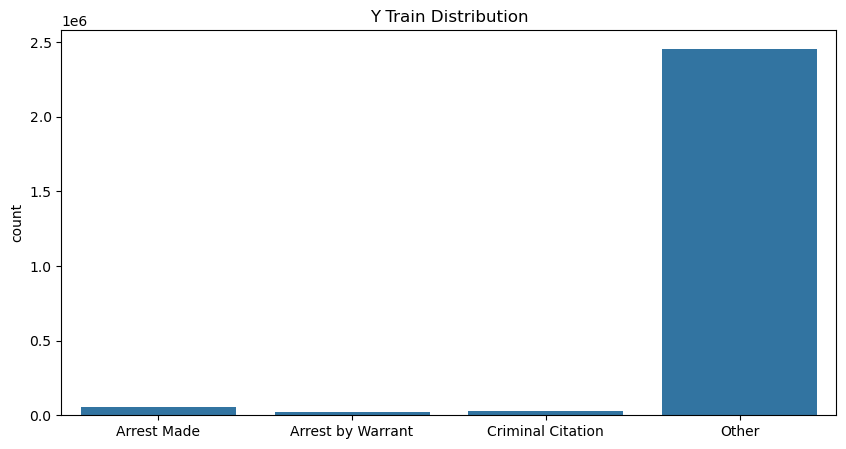

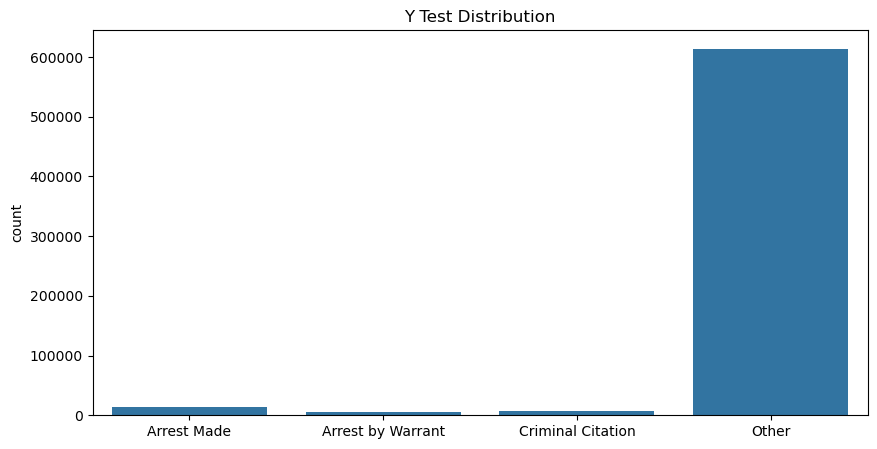

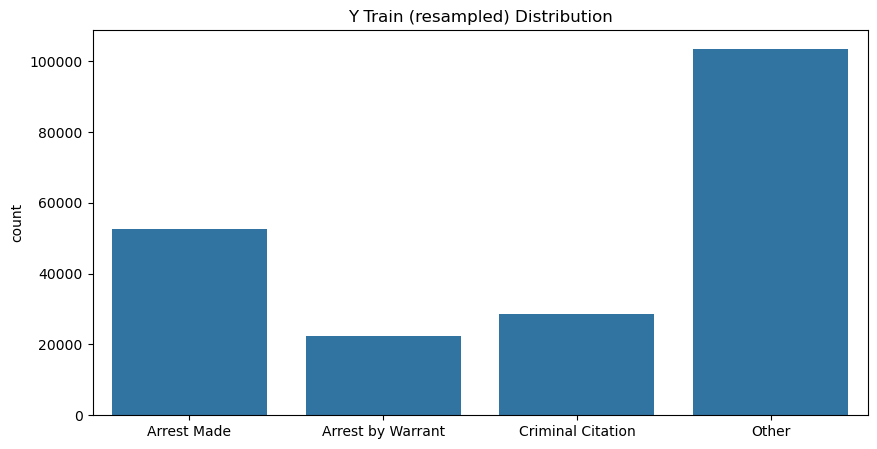

In [823]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [826]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [827]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [828]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00     13149
Arrest by Warrant       0.00      0.00      0.00      5568
Criminal Citation       0.00      0.00      0.00      7170
            Other       0.96      1.00      0.98    614201

         accuracy                           0.96    640088
        macro avg       0.24      0.25      0.24    640088
     weighted avg       0.92      0.96      0.94    640088



### Logistic Regression

In [830]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [831]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [835]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.18      0.67      0.29     13149
Arrest by Warrant       0.59      0.62      0.61      5568
Criminal Citation       0.14      0.49      0.21      7170
            Other       0.99      0.90      0.94    614201

         accuracy                           0.89    640088
        macro avg       0.47      0.67      0.51    640088
     weighted avg       0.96      0.89      0.92    640088



#### Hyperparameter Tuning

In [838]:
grid_search_scoring_method = 'f1_macro'

In [839]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [840]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5689


In [841]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, "models/all_yr_best_logistic_regression.pkl") 

['models/all_yr_best_logistic_regression.pkl']

In [842]:
# load
best_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")

In [843]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.59      0.33      0.42     13149
Arrest by Warrant       0.72      0.62      0.66      5568
Criminal Citation       0.57      0.12      0.20      7170
            Other       0.98      0.99      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.71      0.52      0.57    640088
     weighted avg       0.96      0.97      0.96    640088



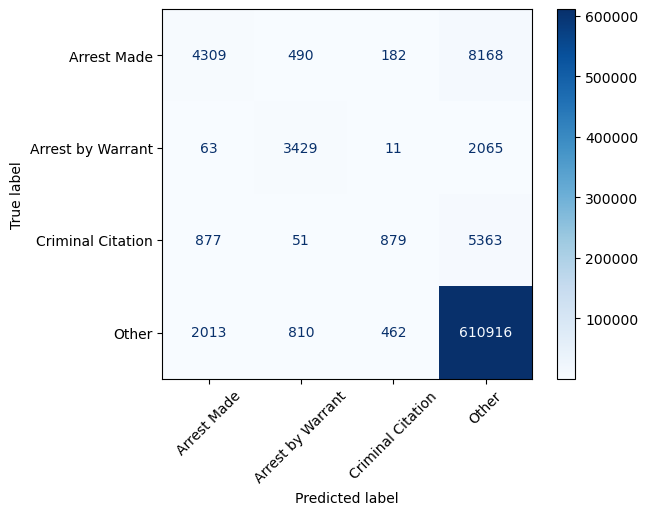

In [844]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [846]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [847]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [848]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.021961
1,neighborhood,0.000352
2,PRIORITY,0.000242
5,DISTANCE_FROM_CENTER,0.000102
3,LATITUDE,0.000073
8,LONGITUDE^2,0.000055
6,LATITUDE^2,0.000029
7,LATITUDE LONGITUDE,0.000008
9,AFTER_COVID_Yes,-0.000005
4,LONGITUDE,-0.000060


In [868]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [870]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping[code]
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                         Feature  Importance  \
200                             CALLTYPE_CODE_6M    0.005476   
199                             CALLTYPE_CODE_6F    0.002885   
184                           CALLTYPE_CODE_601T    0.001906   
64                           CALLTYPE_CODE_11377    0.001286   
67                           CALLTYPE_CODE_11550    0.000651   
8                            CALLTYPE_CODE_1033A    0.000617   
84                           CALLTYPE_CODE_14601    0.000560   
80                           CALLTYPE_CODE_12020    0.000456   
102                          CALLTYPE_CODE_22500    0.000437   
136                            CALLTYPE_CODE_415    0.000419   
107                          CALLTYPE_CODE_23152    0.000346   
86                             CALLTYPE_CODE_148    0.000333   
59                           CALLTYPE_CODE_11300    0.000331   
196                           CALLTYPE_CODE_647F    0.000318   
75                            CALLTYPE_C

In [872]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                          Display Name  Coefficient
184                           Call Type: TRUANT (TABS)     3.372244
198            Call Type: PETTY THEFT PRIOR CONVICTION     2.948785
107                         Call Type: MISDEMEANOR DUI     2.682201
108                              Call Type: FELONY DUI     2.541393
87           Call Type: RESISTING ARREST, GANG RELATED     2.524042
82              Call Type: CARRYING A CONCEALED WEAPON     2.440515
102                       Call Type: PARKING VIOLATION    -2.394975
196                         Call Type: DRUNK IN PUBLIC     2.198630
86                         Call Type: RESISTING ARREST     2.091783
8                            Call Type: ALARM, AUDIBLE    -2.051679
148                      Call Type: DISTURBANCE, MUSIC    -2.047634
76                   Call Type: VEHICLE STOP ON FEMALE    -2.046667
80                          Call Type: ILLEGAL WEAPONS     2.007344
206                       C

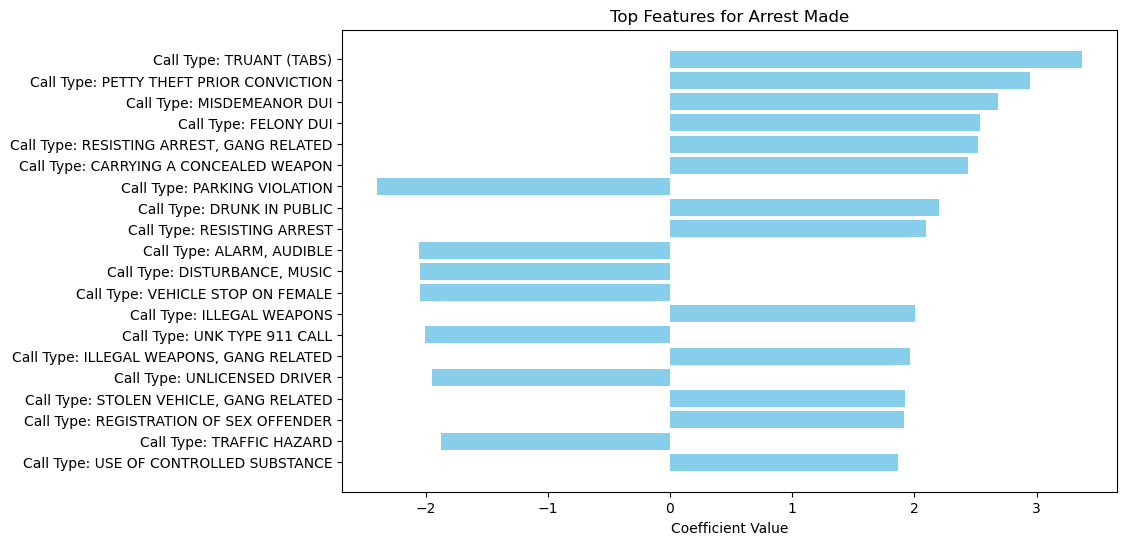

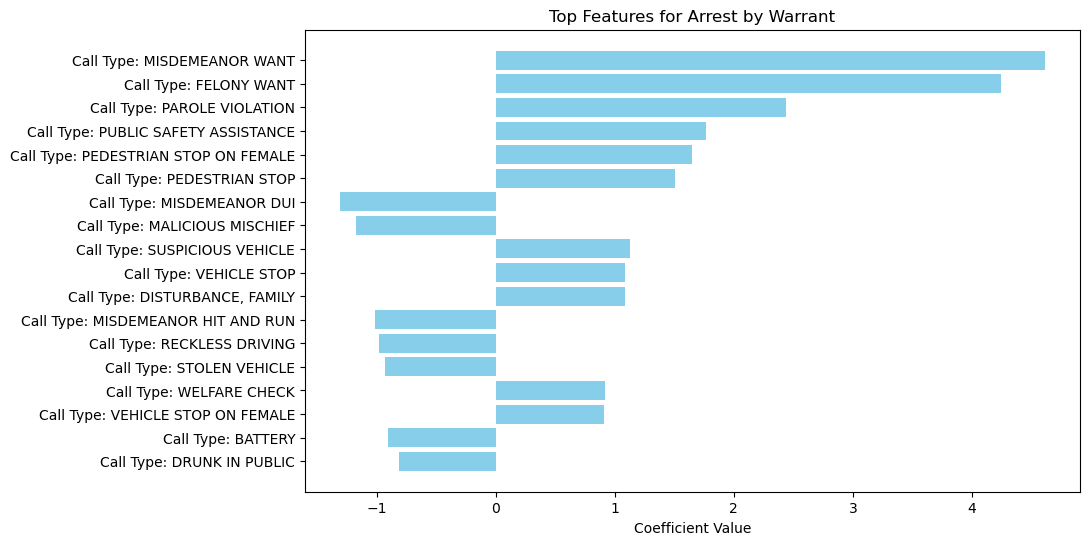

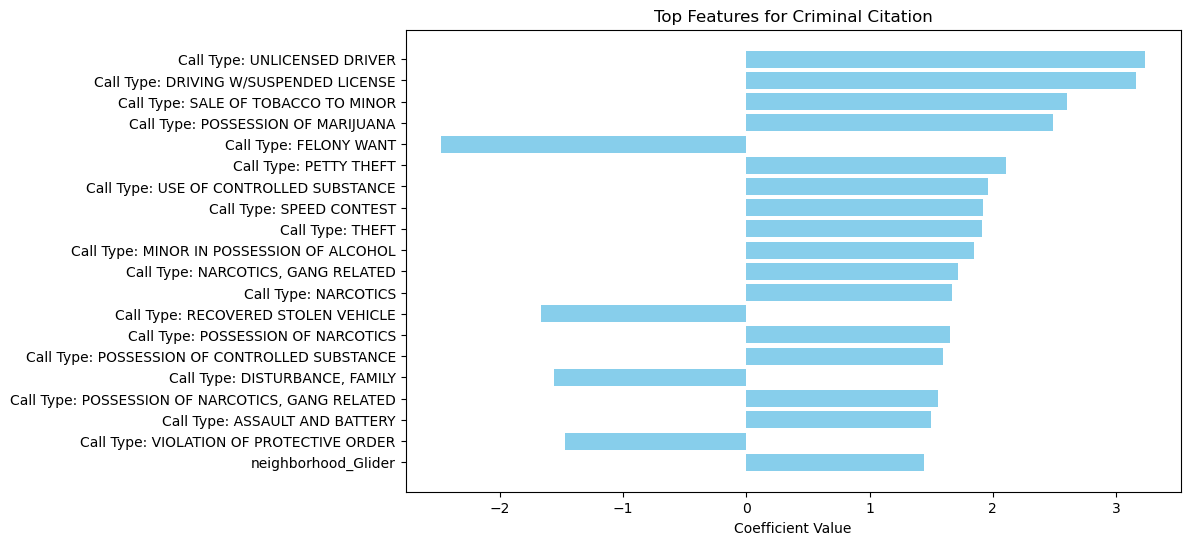

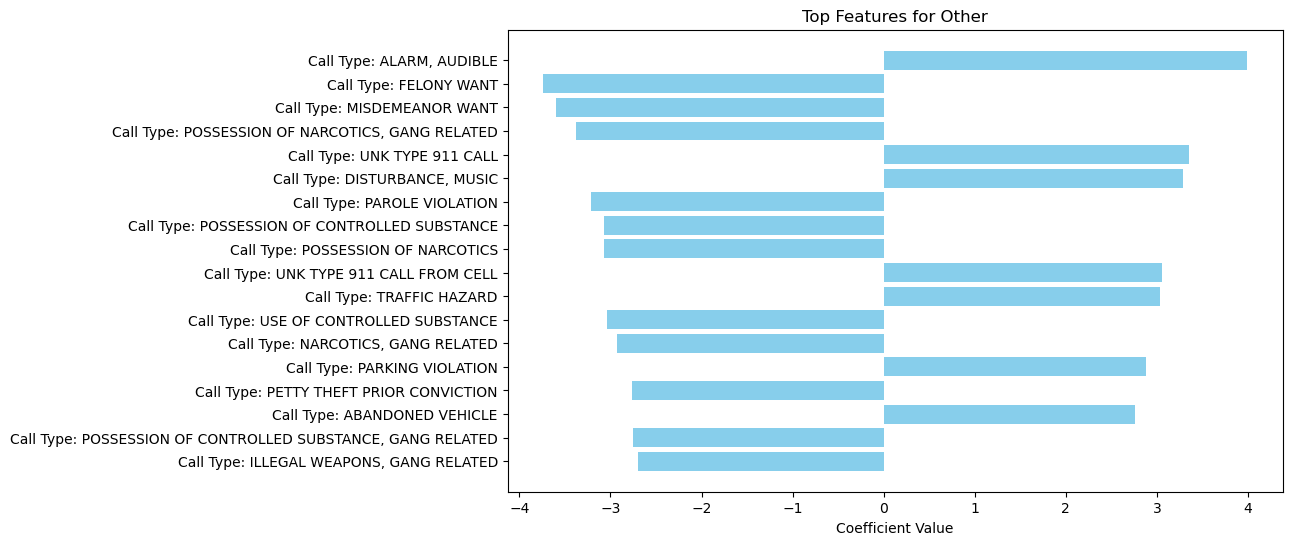

In [874]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [877]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [878]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.36      0.44     13149
Arrest by Warrant       0.68      0.53      0.60      5568
Criminal Citation       0.46      0.22      0.30      7170
            Other       0.98      0.99      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.67      0.53      0.58    640088
     weighted avg       0.96      0.97      0.96    640088



#### Hyperparameter Tuning and Cross Validation

In [880]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=3,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.58


In [881]:
best_rf = grid_rf.best_estimator_

In [882]:
# save
joblib.dump(best_rf, "models/all_yr_best_random_forest.pkl") 

['models/all_yr_best_random_forest.pkl']

In [883]:
best_rf = joblib.load("models/all_yr_best_random_forest.pkl")

In [1027]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.36      0.44     13149
Arrest by Warrant       0.69      0.54      0.60      5568
Criminal Citation       0.47      0.23      0.31      7170
            Other       0.98      0.99      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.67      0.53      0.58    640088
     weighted avg       0.96      0.97      0.96    640088



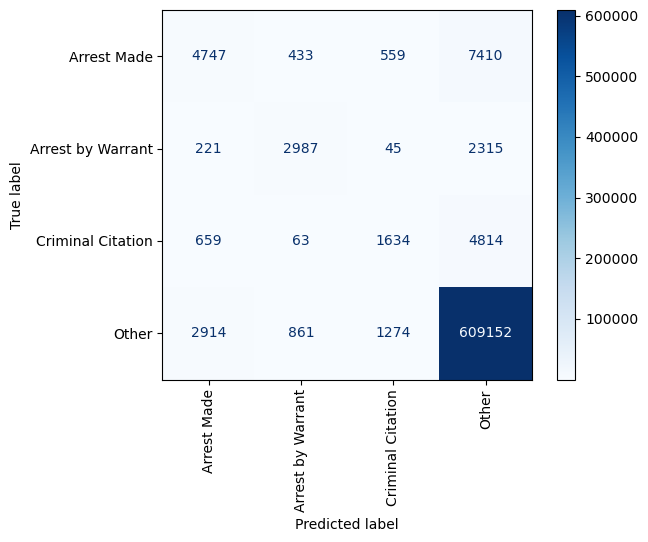

In [885]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [898]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-06 11:53:33,763] A new study created in memory with name: no-name-8fbabc70-42ca-4220-88f3-3d47eca2b31c
[I 2024-10-06 11:53:46,653] Trial 0 finished with value: 0.615655932365491 and parameters: {'n_estimators': 106, 'max_depth': 35, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.615655932365491.
[I 2024-10-06 11:54:00,190] Trial 1 finished with value: 0.656258847382346 and parameters: {'n_estimators': 63, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.656258847382346.
[I 2024-10-06 11:54:11,360] Trial 2 finished with value: 0.5127225673637535 and parameters: {'n_estimators': 128, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.656258847382346.
[I 2024-10-06 11:54:15,809] Trial 3 finished with value: 0.1667268931602736 and parameters: {'n_estimators': 73, 'max_depth': 6, 'min_sa

Best hyperparameters: {'n_estimators': 199, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}


In [899]:
best_params = study.best_params
best_params

{'n_estimators': 199,
 'max_depth': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 8,
 'max_features': 'sqrt'}

In [900]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=3)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=199, n_jobs=3)

In [1025]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.66      0.31      0.43     13149
Arrest by Warrant       0.72      0.61      0.66      5568
Criminal Citation       0.62      0.10      0.17      7170
            Other       0.97      1.00      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.74      0.51      0.56    640088
     weighted avg       0.96      0.97      0.96    640088



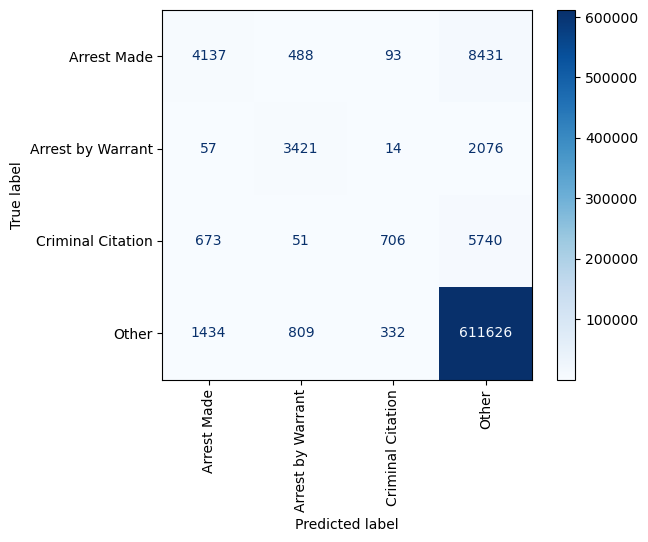

In [906]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

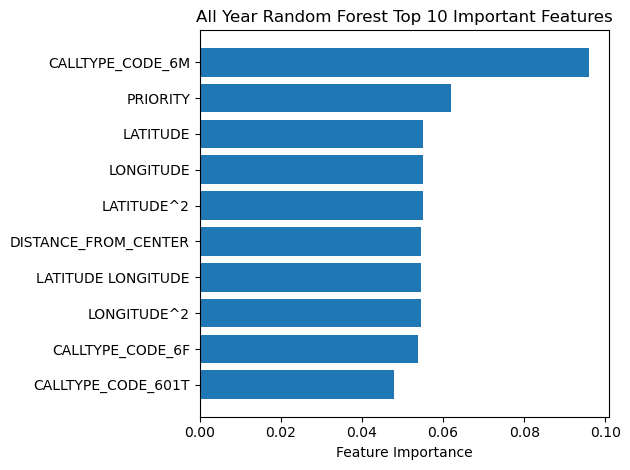

In [909]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [912]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [914]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [916]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [918]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.9657 - loss: 0.1354 - val_accuracy: 0.9690 - val_loss: 0.1156
Epoch 2/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 0.9680 - loss: 0.1191 - val_accuracy: 0.9696 - val_loss: 0.1143
Epoch 3/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.9683 - loss: 0.1173 - val_accuracy: 0.9694 - val_loss: 0.1141
Epoch 4/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.9685 - loss: 0.1171 - val_accuracy: 0.9696 - val_loss: 0.1152
Epoch 5/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.9686 - loss: 0.1163 - val_accuracy: 0.9697 - val_loss: 0.1141
Epoch 6/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.9686 - loss: 0.1167 - val_accuracy: 0.9698 - val_loss: 0.1145
Epoch 7/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.9684 - loss: 0.1172 - val_accuracy: 0.9695 - val_loss: 0.1144
Epoch 8/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 

In [919]:
# save
joblib.dump(mlp_model, "models/all_yr_mlp_model.pkl") 

['models/all_yr_mlp_model.pkl']

In [920]:
mlp_model = joblib.load("models/all_yr_mlp_model.pkl")

In [921]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

20003/20003 ━━━━━━━━━━━━━━━━━━━━ 9s 470us/step - accuracy: 0.9689 - loss: 0.1165
Test Accuracy: 0.9695


In [922]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

20003/20003 ━━━━━━━━━━━━━━━━━━━━ 9s 445us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.63      0.41      0.50     13149
Arrest by Warrant       0.72      0.62      0.66      5568
Criminal Citation       0.55      0.23      0.32      7170
            Other       0.98      0.99      0.99    614201

         accuracy                           0.97    640088
        macro avg       0.72      0.56      0.62    640088
     weighted avg       0.96      0.97      0.97    640088



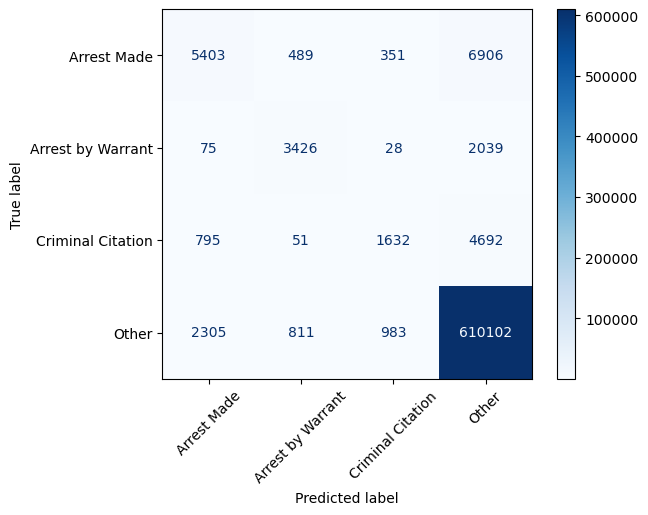

In [923]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [1033]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 15

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-06 17:01:05,502] A new study created in memory with name: no-name-0d8d85df-212e-4a70-877a-d4e89f41125d
[I 2024-10-06 17:03:12,849] Trial 0 finished with value: 0.7090178718916966 and parameters: {'n_estimators': 487, 'learning_rate': 0.08348049665469096, 'max_depth': 5, 'subsample': 0.781987397528061, 'colsample_bytree': 0.7981518366304919, 'gamma': 0.00019106159528178607, 'reg_alpha': 0.0009436802949254085, 'reg_lambda': 1.1872423051923634e-08}. Best is trial 0 with value: 0.7090178718916966.
[I 2024-10-06 17:05:36,101] Trial 1 finished with value: 0.7098014234967934 and parameters: {'n_estimators': 435, 'learning_rate': 0.2715641710410896, 'max_depth': 9, 'subsample': 0.9532562271062711, 'colsample_bytree': 0.7293083672667723, 'gamma': 0.11805649465728607, 'reg_alpha': 0.0002444616194529444, 'reg_lambda': 0.002640688828974741}. Best is trial 1 with value: 0.7098014234967934.
[I 2024-10-06 17:08:02,778] Trial 2 finished with value: 0.691065708813741 and parameters: {'n_esti

Actual runtime: 3750.92 seconds (62.52 minutes)
Best parameters found:  {'n_estimators': 427, 'learning_rate': 0.43788076597392034, 'max_depth': 4, 'subsample': 0.9597473484215658, 'colsample_bytree': 0.755524404216416, 'gamma': 0.5036304452132349, 'reg_alpha': 3.339408654762154e-06, 'reg_lambda': 0.0006964535314033339}
Best F1 macro score:  0.7131337417739626


In [1035]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.755524404216416, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.5036304452132349, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.43788076597392034,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=427, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1036]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.64      0.39      0.49     13149
Arrest by Warrant       0.72      0.61      0.66      5568
Criminal Citation       0.54      0.23      0.32      7170
            Other       0.98      0.99      0.99    614201

         accuracy                           0.97    640088
        macro avg       0.72      0.56      0.61    640088
     weighted avg       0.96      0.97      0.97    640088



In [1037]:
best_xg = xgb_1_model
joblib.dump(best_xg, "models/all_yr_xgb_model.pkl") 

['models/all_yr_xgb_model.pkl']

In [1038]:
best_xg = joblib.load("models/all_yr_xgb_model.pkl")

## Ensemble

In [1039]:
best_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
best_rf = joblib.load("models/all_yr_best_random_forest.pkl")
best_xg = joblib.load("models/all_yr_xgb_model.pkl")

In [1040]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5679295779988628
RF F1: 0.5826321422424283
XGB F1: 0.612662720585142


In [1041]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [1042]:
best_rf

RandomForestClassifier(n_estimators=60)

In [1043]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.755524404216416, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.5036304452132349, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.43788076597392034,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=427, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1044]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [1045]:
X_train_float = X_train.astype('float64')

In [1046]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.755524404216416,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=1)

In [1047]:
joblib.dump(stacking_clf_2, "models/all_yr_stacking_2.pkl") 

['models/all_yr_stacking_2.pkl']

In [1048]:
stacking_clf_2 = joblib.load("models/all_yr_stacking_2.pkl")

In [1049]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6189222109500296


## Results

In [1051]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.959557,0.250000,0.239889,0.244840
Logistic Regression,0.967887,0.515198,0.714711,0.567930
Random Forest,0.966305,0.529287,0.671339,0.582632
MLP,0.969496,0.561787,0.717570,0.616627
XGB,0.969426,0.556121,0.717570,0.612663
Ensemble,0.969548,0.563611,0.716107,0.618922


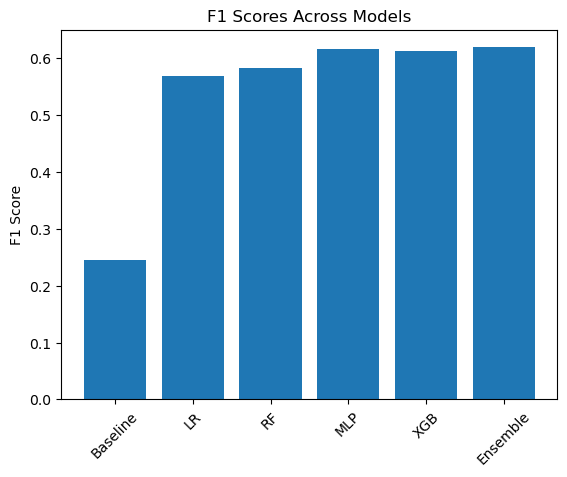

In [1052]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()